##4.2 Simulating a waveform over a single tree
<img src=img/lidar_leaf.gif>

In [26]:
%load_ext autoreload
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from run_start import *
from hips import hips2img

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from generate_camera_file import update_existing_camera

In [67]:
# here we can assume our scene units are ~metres, therefore we 
# need to convert our LiDAR pulse (4 ns) into m.

L = 1e-9 * 299792458 # speed of light m/ns
pl_ln = 4 * L # pulse length @ 4 ns
pl_sd = 1 # how much of a gaussian
boomLength = 10 # height of illumination (and camera)
footprint = 5

update_existing_camera('light/pulse.lidar', 'light/large_footprint.lidar',
                       new_options={'lidar.pulseStart':pl_ln/2.,
                                    'lidar.pulseSD':pl_sd,
                                    'lidar.pulseLength':pl_ln,
                                    'lidar.pulseOPFile':'light/large.pulse',
                                    'geometry.boomLength':10,
                                    'geometry.idealArea':footprint})

we also need to update the camera, using the logic from the previous example: 

if our camera (<code>geometry.boomLength</code>) is 10 units and the top of the tree is at ~6 units then the minimum return distance is 8 units (<code>lidar.binStart</code>). If we set the <code>lidar.binStep</code> to .1 and the total round distance from illumination to ground to camera is 20 then we'll need to set <code>lidar.nBins</code> to $(20-8)/0.1$ 

In [68]:
oname='output/large_footprint' # geometry.idealArea = footprint
hoc = 6 # height of canopy
diff_camera_toc = boomLength - hoc
binStart = diff_camera_toc * 2
binStep = .1
nBins = ((boomLength * 2) - (binStart)) / binStep

update_existing_camera('camera/pulse.lidar', 'camera/large_footprint.lidar', oname=oname,
                       new_options={'geometry.idealArea':footprint,
                                    'geometry.boomLength':boomLength,
                                    'lidar.binStart':binStart,
                                    'lidar.binStep':binStep,
                                    'lidar.nBins':nBins})                                

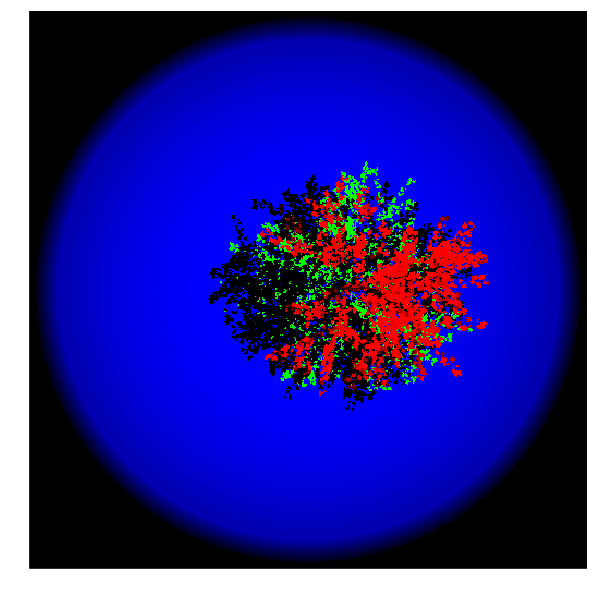

In [69]:
# now we can run the simulation
cmd = 'echo 14 camera/large_footprint.lidar light/large_footprint.lidar | \
       start -RATm 1 -RATsensor_wavebands wb/brdf_waveband.dat obj/birch_tree_scene.obj'
error = run_start(cmd)

if not error:
    # we can look at a slice of the resulting image using the 'order'
    # option, in this case we are looking at lidar.nBins steps 0, 10, 30
    ax = hips2img('{}.hips'.format(oname), stretch=True, 
                  order=[20, 50, 120])

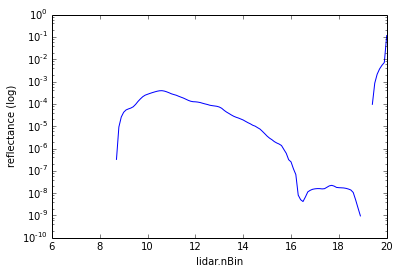

In [70]:
# We can then look at the results of this by plotting
# reflectance against bin number
refl = np.loadtxt('output/large_footprint.dat.direct')
plt.plot(refl[:, 0], refl[:, 1:].mean(axis=1))
plt.yscale('log') # because ground reflectance is high
plt.xlabel('lidar.nBin')
plt.ylabel('reflectance (log)')

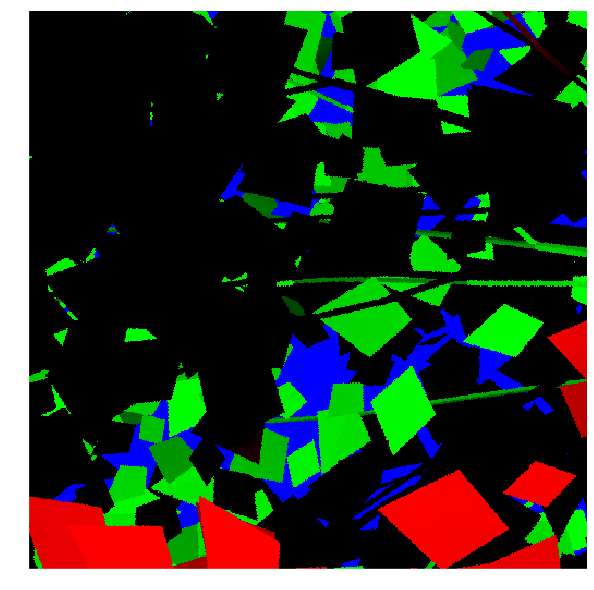

In [72]:
oname='output/small_footprint' # geometry.idealArea = .3
footprint = .3

update_existing_camera('light/pulse.lidar', 'light/small_footprint.lidar',
                       new_options={'lidar.pulseStart':pl_ln/2.,
                                    'lidar.pulseSD':pl_sd,
                                    'lidar.pulseLength':pl_ln,
                                    'lidar.pulseOPFile':'light/small.pulse',
                                    'geometry.boomLength':boomLength,
                                    'geometry.idealArea':footprint})

update_existing_camera('camera/pulse.lidar', 'camera/small_footprint.lidar', oname=oname,
                       new_options={'geometry.idealArea':footprint,
                                    'geometry.boomLength':boomLength,
                                    'lidar.binStart':binStart,
                                    'lidar.binStep':binStep,
                                    'lidar.nBins':nBins})

cmd = 'echo 14 camera/small_footprint.lidar light/small_footprint.lidar | \
       start -RATm 1 -RATsensor_wavebands wb/brdf_waveband.dat obj/birch_tree_scene.obj'
error = run_start(cmd)

if not error:
    # we can look at a slice of the resulting image using the 'order'
    # option, in this case we are looking at lidar.nBins steps 0, 10, 30
    ax = hips2img('{}.hips'.format(oname), stretch=True, 
                  order=[20, 50, 120])

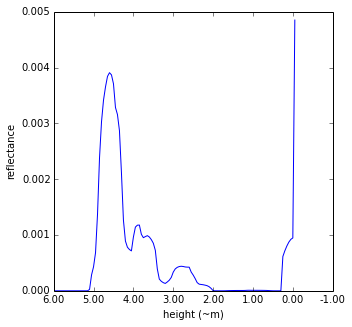

In [103]:
refl = np.loadtxt('output/small_footprint.dat.direct')
plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
ax.plot(refl[:, 1:].mean(axis=1))
ax.set_xticklabels(['{:.2f}'.format(v) for v in hoc - (ax.get_xticks() * binStep) / 2])
ax.set_xlabel('height (~m)')
ax.set_ylabel('reflectance')

In [100]:
hoc - (ax.get_xticks() * binStep) / 2

array([ 6.,  5.,  4.,  3.,  2.,  1.,  0., -1.])

##Changing the pulse spread function
This is achieved by adding a Gaussian function to the light source or the camera.

The additional options required are:

<code>samplingPattern.form</code> <span style=color:green><i># either Gaussian or square</i></span>

<code>samplingPattern.size</code> <span style=color:green><i># size of array steps (not in scene units)</i></span>

<code>samplingPattern.sd</code> <span style=color:green><i># function standard deviation</i></span>

<code>samplingPattern.centre</code> <span style=color:green><i># centre of function (in "size" units (see above))</i></span>

<code>samplingPattern.threshold</code> <span style=color:green><i># see notes below...</i></span>

<code>samplingPattern.OPImage</code> <span style=color:green><i># hips image of function</i></span>

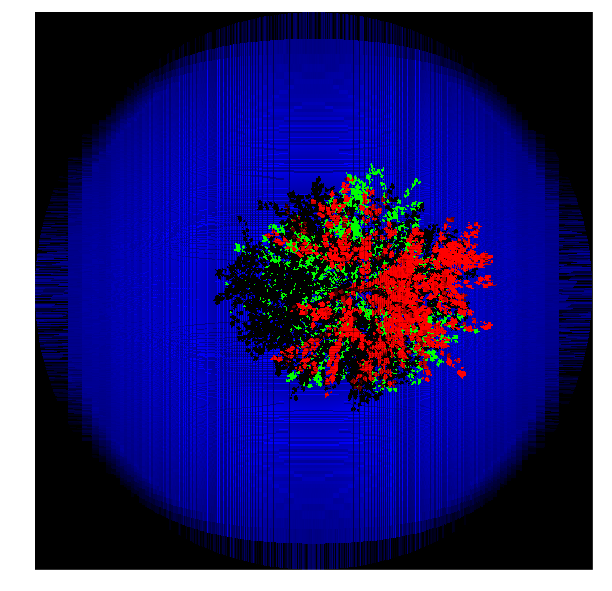

In [64]:
%autoreload 2
from generate_camera_file import update_existing_camera
oname = 'output/lfp_gauss'
update_existing_camera('light/large_footprint.lidar', 'light/lfp_gauss.lidar2',
                       new_options={'samplingPattern.form':'gaussian',
                                    'samplingPattern.size':[5000, 5000],
                                    'samplingPattern.sd':[.1, .1],
                                    'samplingPattern.centre':[3500, 3500],
                                    'samplingPattern.threshold':.1,
                                    'samplingPattern.OPImage':'light/opGaussian.hips'})

update_existing_camera('light/large_footprint.lidar', 'light/lfp_gauss.lidar' , oname=oname)

# now we can run the simulation
cmd = 'echo 14 camera/lfp_gauss.lidar light/lfp_gauss.lidar2 | \
       start -RATm 1 -RATsensor_wavebands wb/brdf_waveband.dat obj/birch_tree_scene.obj'
error = run_start(cmd)

if not error:
    ax = hips2img('{}.hips'.format(oname), stretch=True, 
                  order=[20, 50, 120])

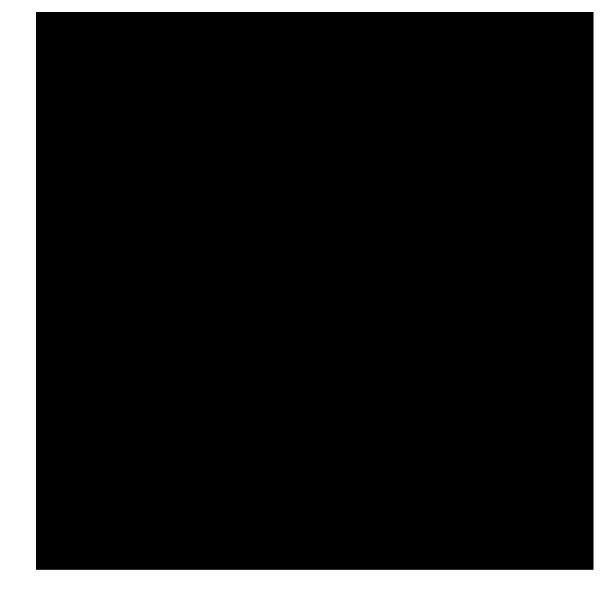

In [65]:
hips2img('light/opGaussian.hips', order=[0])